# Creación de Análisis De Supervivencia

En este caso realizaremos un análisis de supervivencia, para ver las componentes que más puedan afectar que un paciente reingrese
<!--  -->

In [15]:
import pandas as pd

In [16]:
ruta = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/GRD_Completo.parquet'
df = pd.read_parquet(ruta)


In [17]:
# 1. Vista general rápida
print("=== df.info() ===")
df.info()

# 2. Descripción por tipo de dato
print("\n=== Estadísticas numéricas ===")
print(df.describe(include=['number']).T)

print("\n=== Estadísticas categóricas (object) ===")
print(df.describe(include=['object']).T)

# 3. Rango de fechas para columnas datetime
for col in df.select_dtypes(include=['datetime64[ns]']).columns:
    print(f"\n=== Rango en {col} ===")
    print("Mín:", df[col].min(), "Máx:", df[col].max())

# 4. Resumen personalizado por columna
summary = []
n = len(df)
for col in df.columns:
    col_data = df[col]
    dtype = col_data.dtype
    miss = col_data.isnull().sum()
    uniq = col_data.nunique(dropna=False)
    # Construimos un mini-resumen
    if pd.api.types.is_numeric_dtype(col_data):
        desc = col_data.describe().to_dict()
    elif pd.api.types.is_datetime64_any_dtype(col_data):
        desc = {'min': col_data.min(), 'max': col_data.max()}
    else:
        desc = col_data.value_counts(dropna=False).head(10).to_dict()
    summary.append({
        'column': col,
        'dtype': str(dtype),
        'missing_count': miss,
        'missing_pct': round(miss / n * 100, 2),
        'unique_count': uniq,
        'sample_summary': desc
    })

# 5. Convertir a DataFrame y mostrar las métricas clave
summary_df = pd.DataFrame(summary)
print("\n=== Resumen por columna (métricas) ===")
print(summary_df[['column','dtype','missing_count','missing_pct','unique_count']])


=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713650 entries, 0 to 713649
Data columns (total 56 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CIP_ENCRIPTADO       713650 non-null  float64       
 1   SEXO                 713625 non-null  object        
 2   FECHA_NACIMIENTO     713645 non-null  object        
 3   SERVICIO_SALUD       713215 non-null  object        
 4   TIPO_INGRESO         713348 non-null  object        
 5   FECHA_INGRESO        713650 non-null  datetime64[ns]
 6   FECHAALTA            713650 non-null  datetime64[ns]
 7   TIPOALTA             713650 non-null  object        
 8   IR_29301_PESO        713644 non-null  float64       
 9   IR_29301_SEVERIDAD   713644 non-null  float64       
 10  IR_29301_MORTALIDAD  713644 non-null  float64       
 11  EDAD                 713645 non-null  float64       
 12  DIAS_ESTANCIA        713650 non-null  int64         
 

In [18]:
import numpy as np

# 1. Conversión de fechas
# -----------------------
# FECHA_NACIMIENTO está como object: lo convertimos y calculamos edad real
df['FECHA_NACIMIENTO'] = pd.to_datetime(df['FECHA_NACIMIENTO'], dayfirst=True, errors='coerce')
# Recalcular EDAD si hay discrepancias:
edad_calc = (df['FECHAALTA'] - df['FECHA_NACIMIENTO']).dt.days // 365
# Rellenamos EDAD faltante con el cálculo y guardamos la original para validar
df['EDAD'] = df['EDAD'].fillna(edad_calc)

# 2. Imputación de faltantes numéricos
# ------------------------------------
# Todos los numéricos con <0.1% missing → imputar con mediana
num_cols = df.select_dtypes(include=['float64','int64']).columns
for col in num_cols:
    pct = df[col].isna().mean()
    if pct>0 and pct < 0.01:
        df[col] = df[col].fillna(df[col].median())

# 3. Imputación de faltantes categóricos
# --------------------------------------
# SEXO, SERVICIO_SALUD, TIPO_INGRESO, HOSPITAL tienen <2% missing → 'Desconocido'
cat_cols = ['SEXO','SERVICIO_SALUD','TIPO_INGRESO','HOSPITAL']
for col in cat_cols:
    df[col] = df[col].fillna('Desconocido')

# 4. Limpieza de columnas irrelevantes o constantes
# -------------------------------------------------
#   • CIP_ENCRIPTADO: identificador → lo dejamos fuera del modelo
#   • Versión: única categoría → drop
#   • Descripción, Categoría, Capítulo: demasiado granular para Cox; 
#     o bien agrupar (p. ej. top-10) o drop si no las vamos a usar
drop_cols = ['CIP_ENCRIPTADO','Versión']
df = df.drop(columns=drop_cols)

# 5. Procesar procedimientos
# --------------------------
# Hay 30 columnas PROCEDIMIENTO* con altísimo % de missing.
#   • Creamos un feature “num_procedimientos” contando no-nulos
proc_cols = [c for c in df.columns if c.startswith('PROCEDIMIENTO')]
df['num_procedimientos'] = df[proc_cols].notna().sum(axis=1)
#   • Si luego quisieras usar códigos específicos, necesitas agrupar 
#     los más frecuentes o hacer encoding distinto. Por ahora las descartamos:
df = df.drop(columns=proc_cols)

# 6. Codificación de Sección (motivo de ingreso)
# ----------------------------------------------
# 229 categorías: quedarnos con top-10 y agrupar el resto en “Otros”
top10 = df['Sección'].value_counts().nlargest(10).index
df['Sección_grp'] = df['Sección'].where(df['Sección'].isin(top10), 'Otros')
df = pd.get_dummies(df, columns=['Sección_grp'], drop_first=True)

# 7. Definir duración y evento para cada horizonte
# -----------------------------------------------
# Ejemplo 30 días:
h = 30
df[f'duration_{h}d'] = df['DIAS_REINGRESO'].clip(upper=h)
df[f'event_{h}d']    = df[f'READM_{h}D']  # ya es 1/0

# Repite para 7, 60 y 90 días según necesites.



<Axes: >

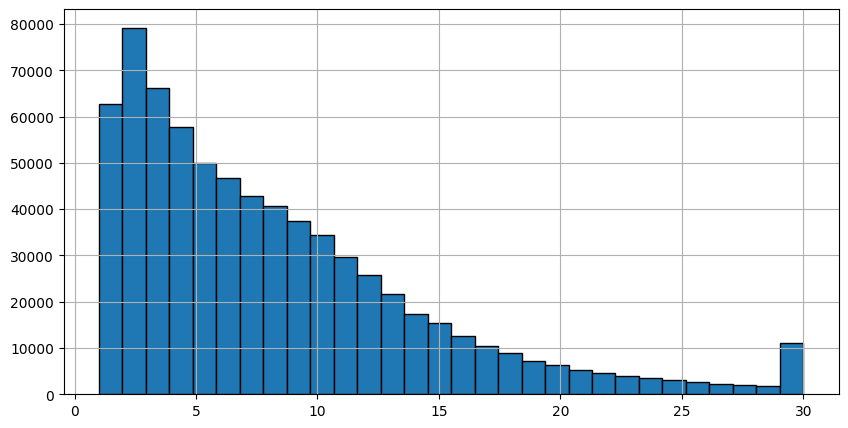

In [19]:
df['num_procedimientos'].hist(bins=30, figsize=(10, 5), edgecolor='black')
#Para ver la distribución de los procedimientos


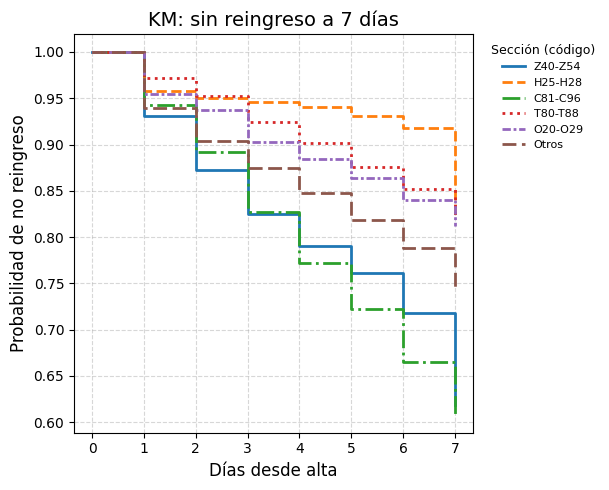

>>> Gráfico KM 7d refinado completado


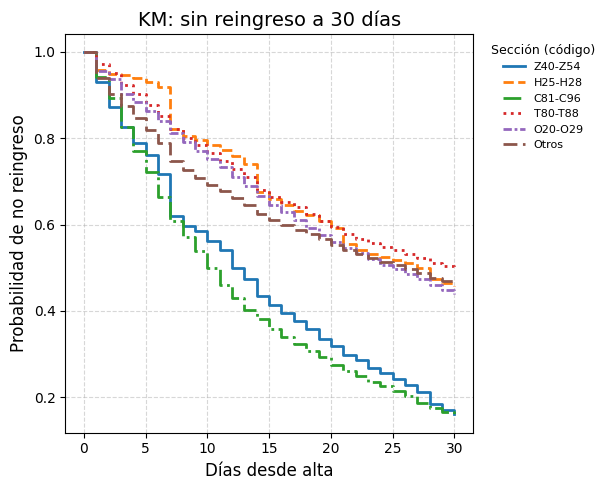

>>> Gráfico KM 30d refinado completado


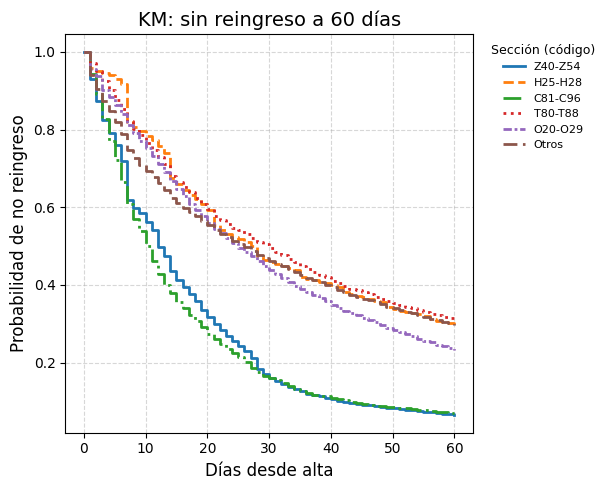

>>> Gráfico KM 60d refinado completado


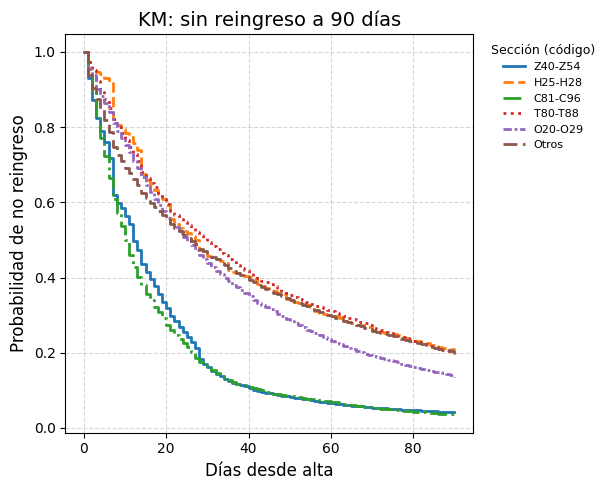

>>> Gráfico KM 90d refinado completado


<lifelines.CoxPHFitter: fitted with 713650 total observations, 293143 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 713650
number of events observed = 420507
   partial log-likelihood = -5475607.64
         time fit was run = 2025-05-12 03:31:43 UTC

---
                                                                                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                       
EDAD                                                                                                           -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
IR_29301_PESO                                                                                                  -0.02      0.98      0.00           -0.02           -0.02                0.98                0.98
IR_29301_SEVERIDAD                                                                                              0.10      1.10      0.00            0.09            0.10                1.10                1.10
IR_29301_MORTALIDAD                                                                                             0.01      1.01      0.00            0.01            0.01                1.01                1.01
num_procedimientos                                                                                             -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Seccion_C81-C96  NEOPLASIA MALIGNA DE TEJIDOS LINFOIDE, HEMOPOÝETICO Y RELACIONADOS                             0.48      1.62      0.01            0.47            0.50                1.60                1.65
Seccion_H25-H28  TRASTORNOS DEL CRISTALINO                                                                      0.15      1.17      0.01            0.14            0.17                1.15                1.19
Seccion_I30-I52  OTRAS FORMAS DE ENFERMEDAD CARDIACA                                                           -0.25      0.78      0.01           -0.27           -0.23                0.76                0.79
Seccion_J09-J18  GRIPE Y NEUMONÍA                                                                              -0.40      0.67      0.01           -0.42           -0.38                0.66                0.68
Seccion_K80-K87  TRASTORNOS DE LA VESÍCULA BILIAR, VÍAS BILIARES Y PÁNCREAS                                    -0.14      0.87      0.01           -0.16           -0.11                0.86                0.89
Seccion_O20-O29  OTROS TRASTORNOS MATERNOS RELACIONADOS PRINCIPALMENTE CON EL EMBARAZO                         -0.18      0.84      0.01           -0.19           -0.16                0.82                0.85
Seccion_O30-O48  ATENCIÓN MATERNA RELACIONADA CON EL FETO Y CAVIDAD AMNIÓTICA Y POSIBLES PROBLEMAS EN EL PARTO  0.09      1.09      0.01            0.07            0.10                1.07                1.11
Seccion_Otros                                                                                                  -0.13      0.88      0.00           -0.14           -0.12                0.87                0.89
Seccion_T80-T88  COMPLICACIONES DE LA ATENCIÓN QUIRÚRGICA Y MÉDICA, NO CLASIFICADAS BAJO OTRO CONCEPTO         -0.16      0.85      0.01           -0.18           -0.14                0.84                0.87
Seccion_Z40-Z54  CONTACTOS PARA OTRA ATENCIÓN ESPECÍFICA DE SALUD                                               0.43      1.53      0.01            0.42            0.44                1.52                1.55
Sexo_H

>>> CoxPH ajustado


'" Nunca comppilamos esto, (Estuvo como 4 horas y no terminó)\ncph.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=True)\nprint(">>> Test Schoenfeld completo")\n'

In [20]:

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from itertools import cycle

# ——————————————————————————————
# 1. Crear Seccion_grp (top-10 + “Otros”)
# ——————————————————————————————
top10 = df['Sección'].value_counts().nlargest(10).index
df['Seccion_grp'] = np.where(df['Sección'].isin(top10), df['Sección'], 'Otros')

# Abreviaciones legibles (códigos de sección)
abreviaciones = {s: s.split()[0] for s in list(top10) + ['Otros']}

# ——————————————————————————————
# 2. Codificar dummies (Seccion_grp y SEXO)
# ——————————————————————————————
secc_dummies = pd.get_dummies(df['Seccion_grp'], prefix='Seccion', drop_first=True)
df['SEXO'] = df['SEXO'].fillna('Desconocido')
sexo_dummies = pd.get_dummies(df['SEXO'], prefix='Sexo', drop_first=True)
df = pd.concat([df, secc_dummies, sexo_dummies], axis=1)

# ——————————————————————————————
# 3. Definir duration/event para cada horizonte
# ——————————————————————————————
horizontes = [7, 30, 60, 90]
for h in horizontes:
    df[f'duration_{h}d'] = df['DIAS_REINGRESO'].clip(upper=h)
    df[f'event_{h}d'] = df[f'READM_{h}D']

# ——————————————————————————————
# 4. Kaplan–Meier: Gráficos refinados por horizonte
# ——————————————————————————————
kmf = KaplanMeierFitter()
line_styles = cycle(['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2))])

grupos = list(top10)[:5] + ['Otros']  # Top-5 + Otros para evitar sobrecarga

for h in horizontes:
    plt.figure(figsize=(8, 5))
    for grupo, ls in zip(grupos, line_styles):
        mask = df['Seccion_grp'] == grupo
        kmf.fit(
            df.loc[mask, f'duration_{h}d'],
            df.loc[mask, f'event_{h}d'],
            label=abreviaciones[grupo]
        )
        kmf.plot_survival_function(
            ci_show=False,
            lw=2,
            ls=ls
        )
    plt.title(f"KM: sin reingreso a {h} días", fontsize=14)
    plt.xlabel("Días desde alta", fontsize=12)
    plt.ylabel("Probabilidad de no reingreso", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(
        title="Sección (código)",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=8,
        title_fontsize=9,
        frameon=False
    )
    plt.tight_layout(rect=[0, 0, 0.78, 1])
    plt.show()
    print(f">>> Gráfico KM {h}d refinado completado")

# ——————————————————————————————
# 5. CoxPH para 30 días (con regularización y sin constantes)
# ——————————————————————————————
h = 30
base_covs  = ['EDAD','IR_29301_PESO','IR_29301_SEVERIDAD','IR_29301_MORTALIDAD','num_procedimientos']
dummy_covs = list(secc_dummies.columns) + list(sexo_dummies.columns)
covs       = base_covs + dummy_covs

df_cox = df[[f'duration_{h}d', f'event_{h}d'] + covs].rename(
    columns={f'duration_{h}d':'duration', f'event_{h}d':'event'})

duplicadas = df_cox.columns[df_cox.columns.duplicated()]
if not duplicadas.empty:
    print("Columnas duplicadas encontradas:", duplicadas.tolist())
    df_cox = df_cox.loc[:, ~df_cox.columns.duplicated()]

# Quitar columnas sin variación
to_drop = df_cox.columns[df_cox.nunique() <= 1]
df_cox.drop(columns=to_drop, inplace=True)

# Asegurar todo numérico
df_cox = df_cox.apply(pd.to_numeric, errors='raise')

# Ajustar modelo con penalización L2
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_cox, duration_col='duration', event_col='event')
cph.print_summary()
print(">>> CoxPH ajustado")

# ——————————————————————————————
# 6. Comprobar proporcionalidad
# ——————————————————————————————
"""" Nunca comppilamos esto, (Estuvo como 4 horas y no terminó)
cph.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=True)
print(">>> Test Schoenfeld completo")
"""

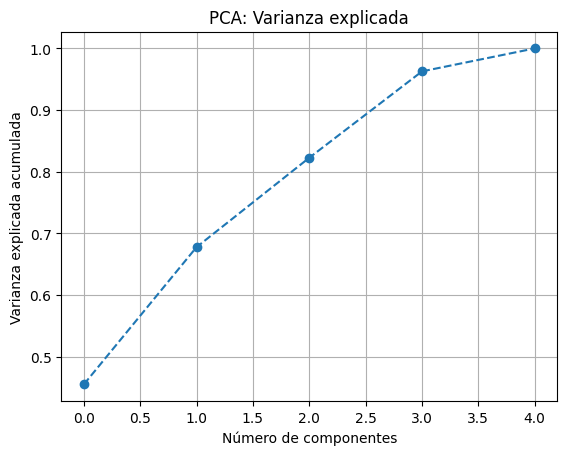

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = df[['EDAD', 'IR_29301_PESO', 'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD', 'num_procedimientos']]

# 2. Escalar
X_scaled = StandardScaler().fit_transform(X)

# 3. Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Graficar varianza explicada
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA: Varianza explicada")
plt.grid()
plt.show()


Realmente la cantidad de procedimientos aplicados explican bastante poco, a edad explica bastante, era muy complicado codificar los hospitales numéricamente, así que lo dejaré para entregas futuras.